# Customer Segmentation of Arvato-Bertelsmann customers

The Arvato-Group is one of total 8 business units in the Bertelsmann Group which is a worldwide operating service company head-quarted in Germany.<br>
The main operating field of Avarto are logistics- and supply chain services and solutions, financial services as well as the operation of IT Systems. Concerning the general figures to get a grasp of the company, the company employs a staff around 77.342 persons (2020) and generates a sales volume of 5.56 Mrd. EUR per a (2024).

The present project can be localized in the financial services branch of Arvato (Arvato Financial Solutions).<br><br>
<span style="color: green;">**One client of Arvato Financial Solutions, a Mail-Order Company selling organic products, wants to be advised concerning a more efficient way to acquire new clients.<br>
In essence, the company wants their acquisition marketing campaings instead of reaching out to everyone (costly), target more precisely those persons which show the highest probability to turn into new customers.**</span>
<br><br>
<span style="text-decoration: underline;">The project spans two main tasks:</span>
1) Customer Segmentation: An Analysis of the existing customer database dataset is carried out and on this basis a general recommandation of which people in Germany are most likely to be new customers of the company is generated. <br><br>
2) Modelling Campaign-Responses: Using the results of 1) to build a machine learning model that predicts whether or not an individual will respond to the respective campaign.

This notebook focuses on the first main task and especially on the EDA.




#### Import relevant libraries and load the data

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 999)
pd.set_option('display.max_colwidth', None)

import os
import re

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

import seaborn as sns

from scipy.stats import skew, kurtosis

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from scipy import stats

%matplotlib inline

In [2]:
#load the relevant data
root_path = os.path.dirname(os.getcwd())

azdias = pd.read_csv(rf'{root_path}\data\customer_segmentation\Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv(rf'{root_path}\data\customer_segmentation\Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

feature_summary = pd.read_excel(rf'{root_path}\data\description\DIAS Attributes - Values 2017.xlsx')

#### Description of the datasets at hand

There are four data files associated with this project:

1) `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
2) `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
3) `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
4) `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

In addition to that, a Feature Summary for the first Dataset is provided.

#############<br>
Whereas the first two files are rather relevant for the customer segmentation (first main task), the later two dataset are more relevant for the second main task (Modelling Campaign-Responses).<br>

The azdias-dataset and the customers-dataset show only a small difference concerning the attributes / columns

In [3]:
np.setdiff1d(
    np.array(customers.columns),
    np.array(azdias.columns),
    assume_unique=True
)

array(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], dtype=object)

Hence, the description of the columns of the datasets at hand can be combined due to the large amount of common columns.<br>
In general, the datasets 1. and 2. contain data where one record describes one individual person over a large amount of attributes-

Arvato provided two excel files containing column-descriptions for the data relevant for the project.
The columns can be distinguished on an "information level" into:<br> 
* <span style="text-decoration: underline;"> **> Person:**</span> data describing the indvidual at hand e.g. age, sex, financial topology, nationality etc.<br><br>
* <span style="text-decoration: underline;"> **> Household:**</span> data describing the circumstances within the household the indivual lives in e.g. no of persons in household, academic titles in household, children in household, transaction activity in Household etc.<br><br>
* <span style="text-decoration: underline;"> **> Building:**</span> data describing the building the household is localized e.g. number of households in the building, type of building, neighbourhood-area indicator etc.<br><br>
* <span style="text-decoration: underline;"> **> Microcell (RR4_ID):**</span> data describing the respective "microcell" (the individual belongs to) by the CAMEO consumer classifications system. <br><br>
* <span style="text-decoration: underline;"> **> Microcell (RR3_ID):**</span> data describing the respective "microcell" (the individual belongs to) by attributes concerning mobility / cars. <br><br>
* <span style="text-decoration: underline;"> **> 125m x 125m Grid**</span> data describing the transactional activity of the individual.<br><br>
* <span style="text-decoration: underline;"> **> Postcode:**</span> data describing the rather geographical context the individual lives in.<br><br>
* <span style="text-decoration: underline;"> **> RR1_ID**</span> data describing the neighbourhood of the individual.<br><br>
* <span style="text-decoration: underline;"> **> PLZ8**</span> data describing the respective geographical area (the individual belongs to) by attributes concerning mobility / cars.<br><br>
* <span style="text-decoration: underline;"> **> Community**</span> data describing the neighbourhood of the individual.

In [4]:
print(f"The azdias dataset has {azdias.shape[0]} rows and {azdias.shape[1]} columns.")
print(f"The customer dataset (of Avarto) has {customers.shape[0]} rows and {customers.shape[1]} columns.")

The azdias dataset has 891221 rows and 366 columns.
The customer dataset (of Avarto) has 191652 rows and 369 columns.


Looking at the information level grouping element, the data can be divided (after some adaptions in the excel file) as follows: 

In [5]:
feature_summary

,Attribute,Description,Value,Meaning,Information_level
0,AGER_TYP,best-ager typology,-1,unknown,Person
1,AGER_TYP,best-ager typology,0,no classification possible,Person
2,AGER_TYP,best-ager typology,1,passive elderly,Person
3,AGER_TYP,best-ager typology,2,cultural elderly,Person
4,AGER_TYP,best-ager typology,3,experience-driven elderly,Person
...,...,...,...,...,...
2253,ZABEOTYP,typification of energy consumers,2,smart,Person
2254,ZABEOTYP,typification of energy consumers,3,fair supplied,Person
2255,ZABEOTYP,typification of energy consumers,4,price driven,Person
2256,ZABEOTYP,typification of energy consumers,5,seeking orientation,Person


In [6]:
attribute_df = customers.columns.to_frame().reset_index(drop = True).rename({0: "Attributes"}, axis = 1)
mapping = feature_summary[["Attribute", "Information_level"]].set_index("Attribute").to_dict(orient="dict", index = True)["Information_level"]
attribute_df["info_level"] = attribute_df["Attributes"].map(mapping).fillna("other")

attribute_df.groupby("info_level").count().sort_values(by = "Attributes", ascending=False).T

info_level,PLZ8,other,Microcell (RR3_ID),Person,Household,125m x 125m Grid,Building,RR1_ID,Postcode,Community,Microcell (RR4_ID)
Attributes,114,97,63,42,22,10,9,5,3,2,2


After having now a certain grasp in which logical categories the data can be classified. We'll have a look which datatypes are present in the datasets:

In [7]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
Name: count, dtype: int64

To close the description of the datasets and proceed to EDA, in the following the attributes under the information level are listed with their respective datatype:

In [8]:
for info_lvl in attribute_df["info_level"].unique():

    df_tmp = attribute_df[attribute_df["info_level"] == info_lvl]

    print(f"Information Level: {info_lvl}\n")
    for col in df_tmp["Attributes"]:
        print(f"{col}, (dtype: {customers[col].dtype})")
        
    print("#"*100, "\n")

Information Level: other

LNR, (dtype: int64)
AKT_DAT_KL, (dtype: float64)
ALTER_KIND1, (dtype: float64)
ALTER_KIND2, (dtype: float64)
ALTER_KIND3, (dtype: float64)
ALTER_KIND4, (dtype: float64)
ALTERSKATEGORIE_FEIN, (dtype: float64)
ANZ_KINDER, (dtype: float64)
ANZ_STATISTISCHE_HAUSHALTE, (dtype: float64)
ARBEIT, (dtype: float64)
CAMEO_INTL_2015, (dtype: object)
CJT_KATALOGNUTZER, (dtype: float64)
CJT_TYP_1, (dtype: float64)
CJT_TYP_2, (dtype: float64)
CJT_TYP_3, (dtype: float64)
CJT_TYP_4, (dtype: float64)
CJT_TYP_5, (dtype: float64)
CJT_TYP_6, (dtype: float64)
D19_BANKEN_DIREKT, (dtype: int64)
D19_BANKEN_GROSS, (dtype: int64)
D19_BANKEN_LOKAL, (dtype: int64)
D19_BANKEN_REST, (dtype: int64)
D19_BEKLEIDUNG_GEH, (dtype: int64)
D19_BEKLEIDUNG_REST, (dtype: int64)
D19_BILDUNG, (dtype: int64)
D19_BIO_OEKO, (dtype: int64)
D19_BUCH_CD, (dtype: int64)
D19_DIGIT_SERV, (dtype: int64)
D19_DROGERIEARTIKEL, (dtype: int64)
D19_ENERGIE, (dtype: int64)
D19_FREIZEIT, (dtype: int64)
D19_GARTEN, (dtype

#### Exploratory Data Analysis

The EDA aims on the one hand to get a general understanding of the data at hand and on the other hand <br>
to find out which steps could be useful for the data cleaning / preparation in the following procedure.

##### (1) What are the general statistical moments of the different attributes of the datasets? 

To get a general understanding of the distinct attributes below the 5 descriptive moment of the two datasets are shown. <br>
It is noticeable that:
* there are 8 attributes which are of the datatype 'object' which should be adressed in data preparation.
* there are several attributes with missing values which has to be investigated further and adressed in data preparation.
* there are at first sight a lot of attributes with skewed distributions 
* there are at first sight a lot of attributes with non-zero kurtosis  

In [11]:
def calc_stat_moments(df):
    """Calculate the 5 general statistical moments of the columns of the given dataframe:
    (0) Non Null Cnt (1) Mean (2) Variance (3) Skewness (4) Kurtosis

    Args:
        df (pandas.DataFrame): Pandas DataFrame to calculate the moments for

    Returns:
        pd.DataFrame with the statistical Moments
    """
    df_ = pd.Series(df.columns.tolist()).to_frame().rename({0: "Attributes"}, axis=1)
    df_["dtype"] = [df[col].dtype for col in df.columns]
    df_["non null cnt"] = [df[col].shape[0] - df[col].isnull().sum() for col in df.columns]
    df_["mean_mode"] = [np.round(df[col].mean().item(),2) if df[col].dtype.kind in "biufc" else df[col].mode()[0] for col in df.columns]
    df_["std"] = [np.round(df[col].var().item(),2) if df[col].dtype.kind in "biufc" else "not numerical" for col in df.columns]
    df_["skewnness"] = [np.round(skew(df[col].dropna(), axis = 0, bias = True),2) if df[col].dtype.kind in "biufc" else "not numerical" for col in df.columns]
    df_["curtosis"] = [np.round(kurtosis(df[col].dropna(), axis = 0, bias = True),2) if df[col].dtype.kind in "biufc" else "not numerical" for col in df.columns]
    
    return df_

In [12]:
calc_stat_moments(azdias)

,Attributes,dtype,non null cnt,mean_mode,std,skewnness,curtosis
0,LNR,int64,891221,637263.0,66189646838.5,-0.0,-1.2
1,AGER_TYP,int64,891221,-0.36,1.44,1.52,0.74
2,AKT_DAT_KL,float64,817722,4.42,13.24,0.29,-1.77
3,ALTER_HH,float64,817722,10.86,58.36,-0.43,-1.36
4,ALTER_KIND1,float64,81058,11.75,16.79,-0.14,-1.03
5,ALTER_KIND2,float64,29499,13.4,10.52,-0.42,-0.6
6,ALTER_KIND3,float64,6170,14.48,7.36,-0.68,-0.05
7,ALTER_KIND4,float64,1205,15.09,6.02,-0.77,-0.05
8,ALTERSKATEGORIE_FEIN,float64,628274,13.7,25.8,-1.05,1.2
9,ANZ_HAUSHALTE_AKTIV,float64,798073,8.29,244.24,8.78,142.62


In [13]:
calc_stat_moments(customers)

,Attributes,dtype,non null cnt,mean_mode,std,skewnness,curtosis
0,LNR,int64,191652,95826.5,3060890063.0,-0.0,-1.2
1,AGER_TYP,int64,191652,0.34,1.94,0.31,-1.49
2,AKT_DAT_KL,float64,145056,1.75,3.87,2.77,6.54
3,ALTER_HH,float64,145056,11.35,39.38,-0.41,-0.64
4,ALTER_KIND1,float64,11766,12.34,16.05,-0.32,-0.93
5,ALTER_KIND2,float64,5100,13.67,10.52,-0.5,-0.56
6,ALTER_KIND3,float64,1275,14.65,7.58,-0.78,0.09
7,ALTER_KIND4,float64,236,15.38,5.33,-0.74,-0.0
8,ALTERSKATEGORIE_FEIN,float64,139810,10.33,17.1,-0.71,1.2
9,ANZ_HAUSHALTE_AKTIV,float64,141725,4.97,204.77,12.06,210.79


##### (2) Missing values

In the file "DIAS Attributes - Values 2017.xlsx", the relevant attributes are listed an described.<br>
Beside description to understand the general meaning of the feature, also the value range of the feature & its meaning is exposed. One Meaning is called 'unknown' and as this value can not be classified with a specific meaning, the records showing these value will be classified as missing (nan).

In [14]:
feature_summary[feature_summary["Meaning"] == "unknown"]

,Attribute,Description,Value,Meaning,Information_level
0,AGER_TYP,best-ager typology,-1,unknown,Person
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,Person
33,ANREDE_KZ,gender,"-1, 0",unknown,Person
40,BALLRAUM,distance to next urban centre,-1,unknown,Postcode
48,BIP_FLAG,business-flag indicating companies in the building,-1,unknown,Building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown,Microcell (RR4_ID)
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typology,-1,unknown,Microcell (RR4_ID)
131,CJT_GESAMTTYP,customer journey typology,0,unknown,Person
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown,Household
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown,Postcode


In [16]:
#create mapping for the unknown values
mapping = {}

feat_unknown = feature_summary[feature_summary["Meaning"] == "unknown"]

for col in feat_unknown["Attribute"].unique():
    ls = feat_unknown[feat_unknown["Attribute"] == col]["Value"].values.tolist()

    if isinstance(ls[0], str):
        mapping[col] = [int(element) for element in ls[0].split(",")]
    else:
        mapping[col] = ls

In [17]:
def replace_unknown_values(df, mapping = mapping):
    """Replace the unknown values in the df with np.nan

    Args:
        df (pd.DataFrame): DataFrame to check
        mapping (dict, optional): Mapping for unknown values. Defaults to mapping.

    Returns:
        _type_: _description_
    """
    df_ = df.copy()

    for col in df_.columns:
        if col in list(mapping.keys()):
            df_[col] = np.where(df_[col].isin(mapping[col]), np.nan, df_[col])  

    df_ = df_.replace(["XX", "X"], np.nan)

    return df_

In [18]:
azdias = replace_unknown_values(azdias, mapping)
customers = replace_unknown_values(customers, mapping)

In [20]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In the further analysis, we are distinguishing between column-wise and row-wise consideration

**Column-wise consideration**

Focusing on the Top 30 missing value attributes, 
* there are several attributes with very high proportions of missing values by column (e.g. ALTER_KINDx)
* there are several attributes with the same proportion of missing values within the datasets

Looking at all values, it is noticeable that both datasets ~ 95 % of the data has not more than 30 % of missing values, but as stated already above some outlier with many missing values.

In [22]:
customers.isnull().mean().sort_values(ascending=False)

ALTER_KIND4                    0.998769
ALTER_KIND3                    0.993347
TITEL_KZ                       0.987936
ALTER_KIND2                    0.973389
ALTER_KIND1                    0.938607
KK_KUNDENTYP                   0.584064
KBA05_BAUMAX                   0.571531
AGER_TYP                       0.480595
EXTSEL992                      0.444989
KKK                            0.313401
REGIOTYP                       0.313401
W_KEIT_KIND_HH                 0.297085
KBA05_AUTOQUOT                 0.296965
KBA05_SEG2                     0.296960
KBA05_SEG8                     0.296960
KBA05_VORB1                    0.296960
KBA05_KRSKLEIN                 0.296960
KBA05_SEG3                     0.296960
KBA05_MAXBJ                    0.296960
KBA05_SEG1                     0.296960
KBA05_KRSVAN                   0.296960
KBA05_KRSZUL                   0.296960
KBA05_KW1                      0.296960
KBA05_KW2                      0.296960
KBA05_KW3                      0.296960


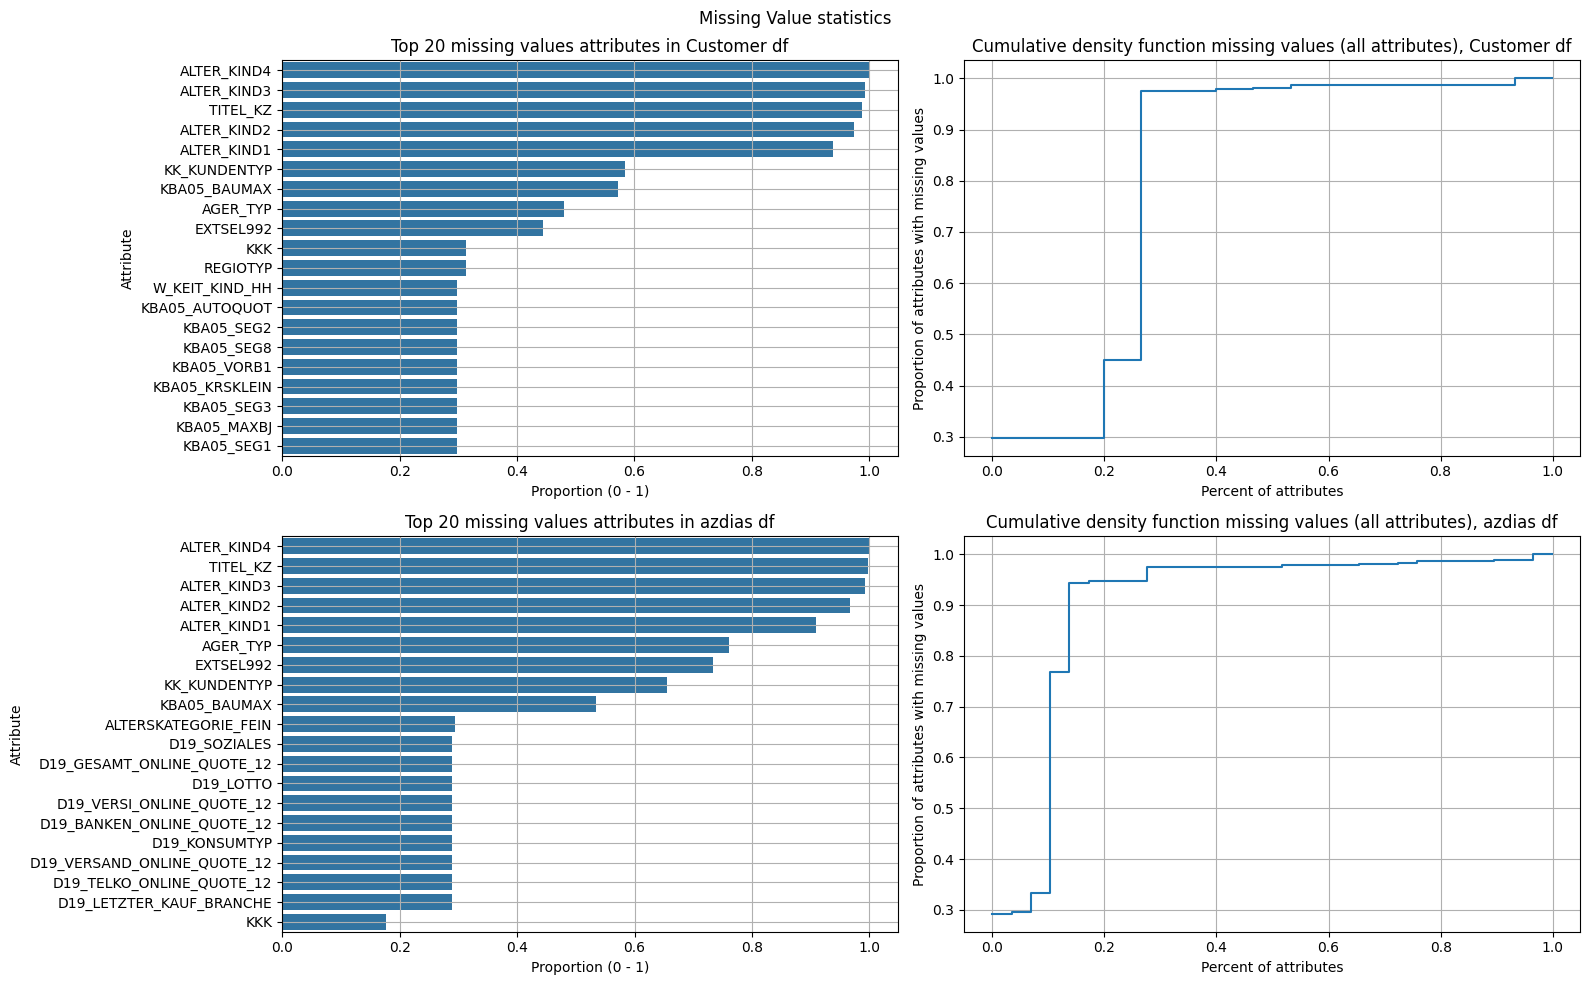

In [23]:
missing_vals_perc_customers = (customers.isnull().sum() / customers.shape[0]).sort_values(ascending=False)
missing_vals_perc_azdias = (azdias.isnull().sum() / azdias.shape[0]).sort_values(ascending=False)

fig, sub = plt.subplots(2, 2, figsize=(16,10))

n = 20

sns.barplot(y = missing_vals_perc_customers.head(n).index, x = missing_vals_perc_customers.head(n), orient = "h", ax = sub[0,0])
sns.histplot(missing_vals_perc_customers, ax = sub[0,1], cumulative=True, kde=False,element='step', stat = "proportion", fill=False)

sns.barplot(y = missing_vals_perc_azdias.head(n).index, x = missing_vals_perc_azdias.head(n), orient = "h", ax = sub[1,0])
sns.histplot(missing_vals_perc_azdias, ax = sub[1,1], cumulative=True, kde=False,element='step', stat = "proportion", fill=False)


[s.grid() for s in sub.flatten()]

#top n missing values ax descr.
[s.set_ylabel("Attribute") for s in [sub[0,0], sub[1,0]]]
[s.set_xlabel("Proportion (0 - 1)") for s in [sub[0,0], sub[1,0]]]

#cdf missing values ax descr.
[s.set_ylabel("Proportion of attributes with missing values") for s in [sub[0,1], sub[1,1]]]
[s.set_xlabel("Percent of attributes") for s in [sub[0,1], sub[1,1]]]

sub[0,0].set_title(f"Top {n} missing values attributes in Customer df")
sub[1,0].set_title(f"Top {n} missing values attributes in azdias df")

sub[0,1].set_title(f"Cumulative density function missing values (all attributes), Customer df")
sub[1,1].set_title(f"Cumulative density function missing values (all attributes), azdias df")

fig.suptitle(f"Missing Value statistics")

fig.tight_layout()

Beside the plots above which provide a good impression of the situation, in the following a missing value summary is created to see a bit more specifically which attribute shows which amount of missing value proportion:

In [24]:
def create_missing_value_summary(df):
    """Create missing value summary of a provided dataframe

    Args:
        df (pandas.DataFrame): dataframe to create the missing val summary from

    Returns:
        pandas.DataFrame: missing value summary
    """


    df_ = pd.concat([
        df.isnull().sum().reset_index(name="missing_vals"),
        np.round(df.isnull().sum().reset_index(name="missing_vals_perc")["missing_vals_perc"] / df.shape[0], 2)
    ], axis = 1)

    df_.rename({"index": "Attribute"}, axis = 1, inplace = True)
    df_ = df_[df_["missing_vals"] != 0]

    return df_.sort_values(by = "missing_vals_perc", ascending=False)

In [25]:
missing_value_summary = pd.merge(
    left = create_missing_value_summary(azdias),
    right = create_missing_value_summary(customers),
    how = "outer",
    left_on = "Attribute", 
    right_on= "Attribute",
    suffixes=["_azdias", "_customers"])

In [26]:
missing_value_summary.sort_values("missing_vals_perc_customers", ascending=False)

,Attribute,missing_vals_azdias,missing_vals_perc_azdias,missing_vals_customers,missing_vals_perc_customers
7,ALTER_KIND4,890016,1.00,191416,1.00
6,ALTER_KIND3,885051,0.99,190377,0.99
265,TITEL_KZ,889061,1.00,189340,0.99
5,ALTER_KIND2,861722,0.97,186552,0.97
4,ALTER_KIND1,810163,0.91,179886,0.94
232,KK_KUNDENTYP,584612,0.66,111937,0.58
60,KBA05_BAUMAX,476524,0.53,109535,0.57
0,AGER_TYP,677503,0.76,92107,0.48
40,EXTSEL992,654153,0.73,85283,0.44
231,KKK,158064,0.18,60064,0.31


In [29]:
#create a drop list for columns with missing values > 35 %
missing_perc_azdias = azdias.isnull().sum() / azdias.shape[0]
missing_perc_azdias[missing_perc_azdias>0.35].sort_values(ascending = False)

ALTER_KIND4     0.998648
TITEL_KZ        0.997576
ALTER_KIND3     0.993077
ALTER_KIND2     0.966900
ALTER_KIND1     0.909048
AGER_TYP        0.760196
EXTSEL992       0.733996
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64

In [30]:
missing_perc_customers = customers.isnull().sum() / customers.shape[0]
missing_perc_customers[missing_perc_customers>0.35].sort_values(ascending = False)

ALTER_KIND4     0.998769
ALTER_KIND3     0.993347
TITEL_KZ        0.987936
ALTER_KIND2     0.973389
ALTER_KIND1     0.938607
KK_KUNDENTYP    0.584064
KBA05_BAUMAX    0.571531
AGER_TYP        0.480595
EXTSEL992       0.444989
dtype: float64

**Row-wise consideration**

In the customer database, there seem to be a lot of customer ids which show a lot (> 250) nan-values on the attributes:

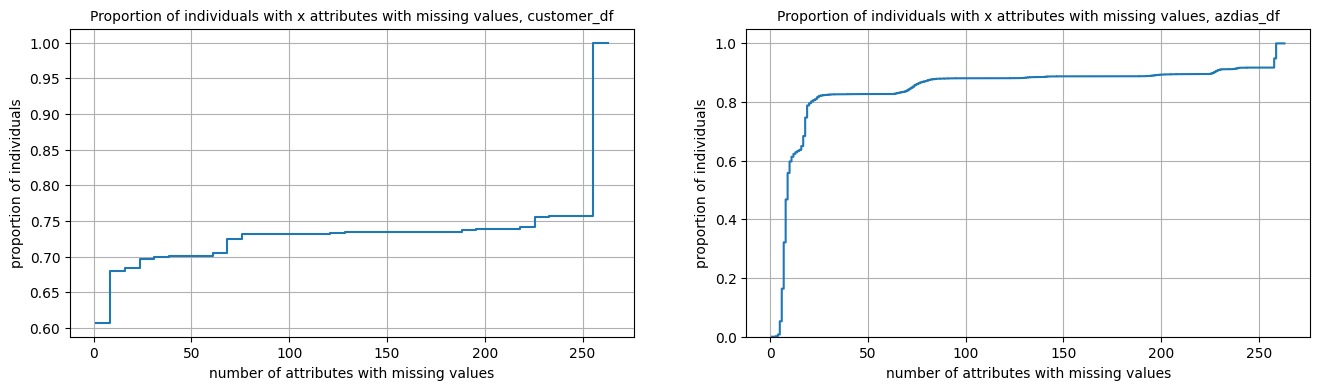

In [31]:
fig, sub = plt.subplots(1,2,figsize = (16,4))

sns.histplot(customers.isnull().sum(axis = 1).sort_values(ascending=True), ax = sub[0], kde=False,element='step', stat = "proportion", fill=False, cumulative=True)
sns.histplot(azdias.isnull().sum(axis = 1).sort_values(ascending=True), ax = sub[1], kde=False,element='step', stat = "proportion", fill=False, cumulative=True)

sub[0].grid()
sub[1].grid()

sub[0].set_xlabel("number of attributes with missing values")
sub[0].set_ylabel("proportion of individuals")
sub[0].set_title("Proportion of individuals with x attributes with missing values, customer_df", fontdict={"size":10})

sub[1].set_xlabel("number of attributes with missing values")
sub[1].set_ylabel("proportion of individuals")
sub[1].set_title("Proportion of individuals with x attributes with missing values, azdias_df",fontdict={"size":10});

In [107]:
#Number of rows with > 250 missing attributes
abs_missing_ax_1 = customers.isnull().sum(axis = 1)[customers.isnull().sum(axis = 1)>250].shape[0]
rel_missing_ax_1 = customers.isnull().sum(axis = 1)[customers.isnull().sum(axis = 1)>250].shape[0] / customers.shape[0]

print(f"In absolute numbers, there are {abs_missing_ax_1} rows, where more than 250 attributes don't show any values which \nis roundabout {np.round(rel_missing_ax_1,2)*100 } % of rows of the whole dataset.")

In absolute numbers, there are 46623 rows, where more than 250 attributes don't show any values which 
is roundabout 24.0 % of rows of the whole dataset.


Looking at the attribute level, the following percentages of missing values can be observed:

In [109]:
customer_null_rowb = customers.isnull().sum(axis = 1)
customer_ls = customer_null_rowb[customer_null_rowb>250].index.tolist()

In [110]:
(customers.loc[customer_ls].isnull().sum() / customers.shape[0]).sort_values(ascending=False)

WOHNLAGE                       0.243269
VHN                            0.243269
ORTSGR_KLS9                    0.243269
OST_WEST_KZ                    0.243269
PLZ8_ANTG1                     0.243269
PLZ8_ANTG2                     0.243269
PLZ8_ANTG3                     0.243269
PLZ8_ANTG4                     0.243269
MIN_GEBAEUDEJAHR               0.243269
MOBI_RASTER                    0.243269
MOBI_REGIO                     0.243269
KBA13_VORB_3                   0.243269
KBA13_VW                       0.243269
KKK                            0.243269
KONSUMZELLE                    0.243269
KBA13_SITZE_4                  0.243269
KBA13_SITZE_5                  0.243269
KBA13_SITZE_6                  0.243269
KBA13_TOYOTA                   0.243269
KBA13_VORB_0                   0.243269
KBA13_VORB_1                   0.243269
KBA13_VORB_1_2                 0.243269
KBA13_VORB_2                   0.243269
KBA13_SEG_MITTELKLASSE         0.243269
KBA13_SEG_OBEREMITTELKLASSE    0.243269


Based on this analysis, in the data preparation part of the notebook, it is necessary to adress: 
* the decision which attributes should be rather dropped due to high number of missing values
* the way to handle the attributes with missing values which should not be discarded (e.g. decision on imputation method)
* which of the customers could potentially be dropped due to high missing values

##### (3) Looking at a sample to get a grasp of the data

In [51]:
azdias.loc[[0,40,504,54053, 42423,93543, 342342]]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

To get a general feeling for the data at hand, 7 records are roughly analyzed by looking over all columns noting all topics which are eye-catching and could be interesting for the further procedure.<br>

Notes: 
* LNR is an id and could be dropped, because it doesn't describe the individual in a qualitative way
* There are several categorical features which has to be processed accordingly in the following analysis (pot. feature engineering, encoding etc.)
* There could be some features which have a low cardinality which means that the features has only few (extreme: just one) value to take on. These feature must be filtered out of the dataset before proceeding (e.g. maybe "D19_BUCH_CD" and more)
* There is an attribute "EINGEFUEGT_AM" which means "INSERTED_ON" and it has to be verified if this is really a necessary information for our analysis
* Without really knowing it, there could be some variables which are correlated / expressing the same amount of information and it should be verified if we could reduce the dataset by identifying these features
* the feature Praegende_Jugendjahre should be investigated further

##### (4) Get to know the data 

For a customer segmentation task, it is not only necessary to apply the statistical method leading us to the different clusters, but also to understand the data in depth to
be capable of decide which data preprocessing steps we need to do and also to be capable of interpreting the results of the whole analysis.

This is why this section of the analysis is dedicated to the understanding of the individuals at hand in the two datasets by creating fundamental descriptive statistics for different attributes.

In [52]:
def get_mapping(feature):
    """Function to provide a feature mapping from feature values to meaning of these values

    Args:
        feature (str): Feature to provide a mapping for

    Raises:
        LookupError: if a feature is not found in the feature_summary dataframe. This error is raised to inform the user of the non-existence

    Returns:
        dict: Dictionary with the mapping feature_value:meaning 
    """

    if feature in feature_summary["Attribute"].unique().tolist():
        mapping_ = feature_summary[feature_summary["Attribute"] == feature][["Value", "Meaning"]].set_index("Value").to_dict()["Meaning"]
    else:
        raise LookupError("Can't find the provided feature in data.")

    return mapping_

**Gender and Age**

In [53]:
def create_gender_age_info(df):
    """Create a gender_age_info dataframe for further preprocessing

    Args:
        df (pandas.DataFrame): Input dataframe
    Return:
        gender_age_info (pandas.DataFrame): Output dataframe
    """
    gender_age_info = df.groupby(["ANREDE_KZ","ALTERSKATEGORIE_GROB"], as_index=False)["LNR"].count().rename({"LNR": "cnt"}, axis = 1)
    gender_age_info["perc"] = gender_age_info["cnt"] / df.shape[0]

    age_mapping = get_mapping("ALTERSKATEGORIE_GROB")
    gender_mapping = get_mapping("ANREDE_KZ")

    gender_age_info["Age_cat"] = gender_age_info["ALTERSKATEGORIE_GROB"].map(age_mapping)
    gender_age_info["gender_cat"] = gender_age_info["ANREDE_KZ"].map(gender_mapping)

    return gender_age_info

def plot_gender_age_info(gender_age_info_, name = "no name provided"):
    """Plot the gender_age_info DataFrame

    Args:
        gender_age_info_ (pandas.DataFrame): input dataframe generated via 'create_gender_age_info' fct
        name (str): name of the dataset the gender_age_info has been created on
    Returns:
        None
    """
    fig, sub = plt.subplots(1,2,figsize=(16,5))

    sns.barplot(x = gender_age_info_["gender_cat"], y = gender_age_info_["cnt"], ax = sub[0], edgecolor = "black")
    sns.barplot(data = gender_age_info_, x = 'gender_cat', y = "perc", hue="Age_cat", edgecolor = "black", palette="viridis", ax=sub[1])

    sub[0].set_ylabel("Record count in whole dataset")
    sub[1].set_ylabel("Percentage of whole dataset")

    [s.grid() for s in sub.flatten()]
    sub[1].legend(loc='upper right')
    fig.suptitle(f"Gender and Age Analysis of the individuals ({name})");


In [54]:
gender_age_info_azdias = create_gender_age_info(azdias)
gender_age_info_customers = create_gender_age_info(customers)

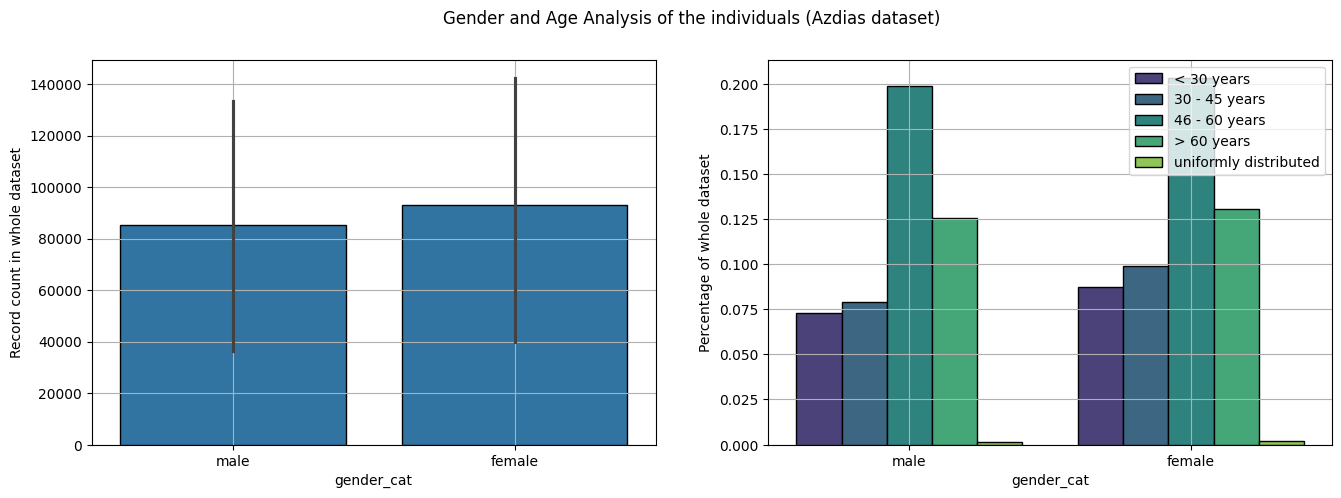

In [55]:
plot_gender_age_info(gender_age_info_azdias, "Azdias dataset")

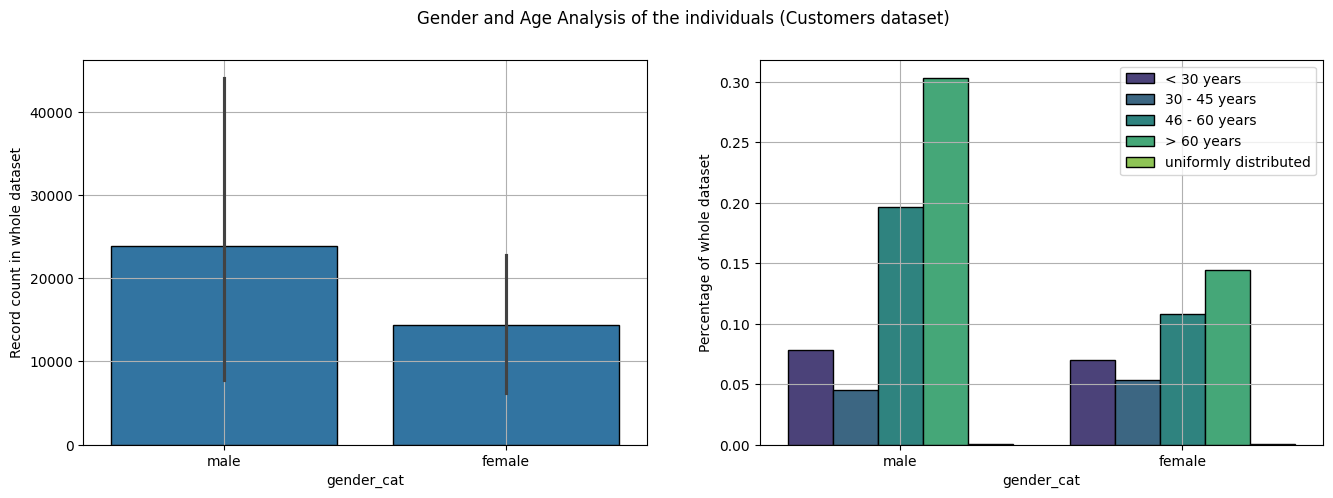

In [56]:
plot_gender_age_info(gender_age_info_customers, "Customers dataset")

* The indivuals in the dataset "azdias" are more or less equally distributed between male / female. In the customers dataset, the part of male indivuals outweighs the female ones.
* Concerning the age, the individuals in both datasets seeem to belong on a high stake to a higher age class (~46 - >60 years)
* In the customers dataset the customers in the age group '> 60 years' even take a proportion of ~ 45 % and the '46 - 60 years' old follow with ~ 30 %

**Family situation and Status**

In [57]:
def create_pvt(df, index, column, vals):
    """Create a pivot dataframe based on an input df

    Args:
        df (pandas.DataFrame): input df, should at lead 
        index (str): Feature for index of the resulting pivot table
        column (str): Feature for columns of the resulting pivot table
        vals (str): Feature to count on
    Returns:
        tuple: tuple of two Dataframes: 1) pivot abs values 2) normalized pivot
    """
    output_pvt = pd.pivot_table(
        data = df,
        values = vals,
        index = index,
        columns = column,
        aggfunc="count",
        margins=True,
        observed=True
    )
    
    normalized_pvt = output_pvt / df.shape[0]

    output_pvt_styled = output_pvt.style.background_gradient(cmap='coolwarm')
    normalized_pvt_styled = normalized_pvt.style.background_gradient(cmap='coolwarm')

    return output_pvt_styled, normalized_pvt_styled 

In [58]:
pvt_family_status_azdias, pvt_family_status_azdias_norm = create_pvt(
                                                            azdias, 
                                                            index = "LP_FAMILIE_FEIN",
                                                            column = "LP_STATUS_GROB",
                                                            vals = "LNR"
                                                            )

pvt_family_status_customers, pvt_family_status_customers_norm = create_pvt(
                                                            customers, 
                                                            index = "LP_FAMILIE_FEIN",
                                                            column = "LP_STATUS_GROB",
                                                            vals = "LNR"
                                                            )

In [59]:
pvt_family_status_azdias_norm

LP_STATUS_GROB,1.000000,2.000000,3.000000,4.000000,5.000000,All
LP_FAMILIE_FEIN,,,,,,
0.000000,0.014029,0.057103,0.000235,0.007190,0.003284,0.081841
1.000000,0.239860,0.108825,0.015106,0.075952,0.038678,0.478421
2.000000,0.037662,0.023426,0.006747,0.026594,0.022607,0.117036
3.000000,0.002880,0.001127,0.000132,0.001081,0.000343,0.005563
4.000000,0.006316,0.003147,0.000392,0.002584,0.001366,0.013805
5.000000,0.005128,0.003832,0.000498,0.002044,0.001873,0.013375
6.000000,0.003127,0.001885,0.000470,0.002996,0.001645,0.010123
7.000000,0.005696,0.003936,0.001417,0.007114,0.005098,0.023260
8.000000,0.004744,0.005814,0.002134,0.006132,0.007018,0.025843


In [60]:
pvt_family_status_customers_norm

LP_STATUS_GROB,1.000000,2.000000,3.000000,4.000000,5.000000,All
LP_FAMILIE_FEIN,,,,,,
0.000000,0.008343,0.219272,0.000334,0.009267,0.009945,0.247162
1.000000,0.053498,0.045797,0.015361,0.043689,0.054380,0.212724
2.000000,0.018701,0.022264,0.018163,0.033514,0.058345,0.150987
3.000000,0.000193,0.000141,0.000042,0.000250,0.000183,0.000809
4.000000,0.000480,0.000454,0.000141,0.000892,0.000871,0.002838
5.000000,0.000558,0.000725,0.000412,0.001211,0.001805,0.004712
6.000000,0.000657,0.000626,0.000266,0.001404,0.001383,0.004336
7.000000,0.001023,0.001190,0.001805,0.005306,0.006120,0.015445
8.000000,0.001075,0.001675,0.003225,0.006627,0.011850,0.024451


LP_FAMILIE_FEIN

* In both datasets seem to show high stakes of individuals living in a single household (LP_FAMILIE_FEIN = 1.0 | azdias: ~ 48 %, customers: 21 %)
* A significant proportion is also living in a 2 or more generation household (LP_FAMILIE_FEIN = 10 - 11 | azdias: ~ 20 %, customers: ~ 30 %)
* Around 12 % in Azdias Dataset is living in a couple against ~ 15 % in the customers dataset.(LP_FAMILIE_FEIN = 2.0)
* A value of the Attribute "LP_FAMILIE_FEIN" (=0) is not shown in the description, but as the value is available in both datasets, we assume that the value is correct
* the fact that a considerable proportion of the customers / individuals in the datasets living in a single household is in line with the fact that many individuals are of a higher age (at higher age, people / partner may pass away and the other half of the couple stays in a single household)

LP_STATUS_GROB

* around 63 % of the individuals in Azdias dataset are classified as low-income earners (LP_STATUS_GROß = 1.0 - 2.0), whereas 43 % in the customer dataset belong to this category
* the customer dataset seem to contain a higher proportion of average earners (LP_STATUS_GROB = 3-5 | ~ 54 %) and the Azdias dataset with ~ 36 % a lower part of average earners.

**Nationality and Location**

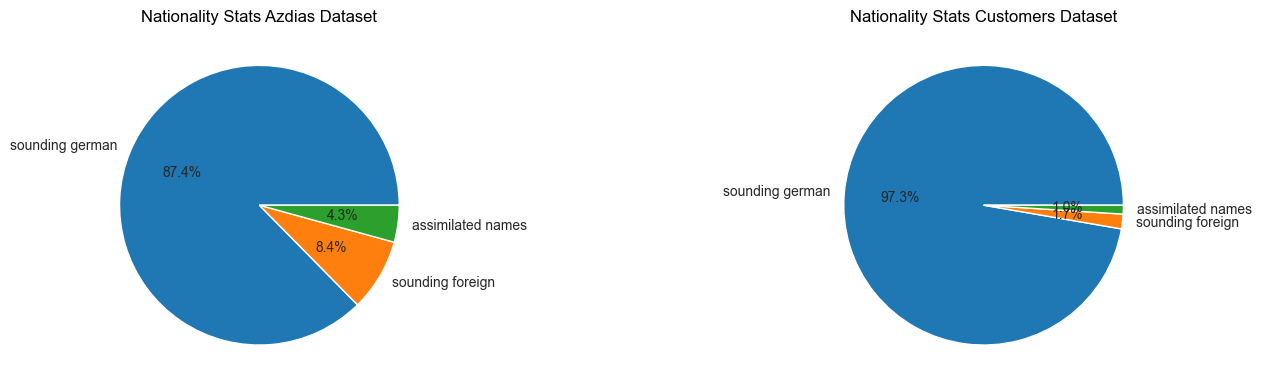

In [61]:
nationality_mapping = get_mapping("NATIONALITAET_KZ") 

nationality_azdias = azdias["NATIONALITAET_KZ"].map(nationality_mapping)
nationality_customers = customers["NATIONALITAET_KZ"].map(nationality_mapping)

nationality_azdias = nationality_azdias.value_counts(normalize=True)
nationality_customers = nationality_customers.value_counts(normalize=True)

fig, sub = plt.subplots(1,2,figsize=(15,4))
sns.set_style("whitegrid")

sub[0].pie(
    nationality_azdias,
    labels = nationality_azdias.index,
    autopct = "%1.1f%%"
)

sub[1].pie(
    nationality_customers,
    labels = nationality_customers.index,
    autopct = "%1.1f%%",
)

sub[0].set_title("Nationality Stats Azdias Dataset")
sub[1].set_title("Nationality Stats Customers Dataset")

fig.tight_layout();

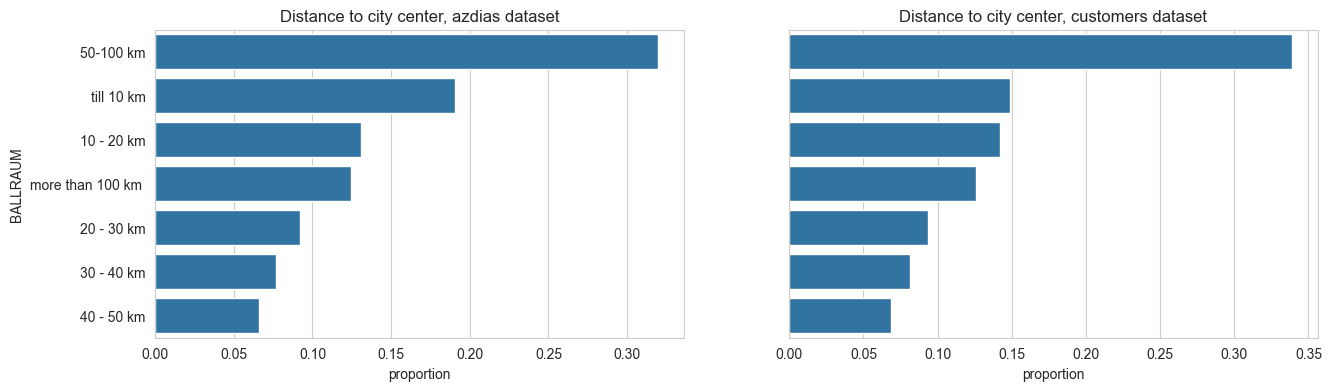

In [62]:
mapping_ballraum = get_mapping("BALLRAUM")

ball_raum_azdias = azdias["BALLRAUM"].map(mapping_ballraum)
ball_raum_customers = customers["BALLRAUM"].map(mapping_ballraum)

ball_raum_azdias = ball_raum_azdias.value_counts(normalize=True)
ball_raum_customers = ball_raum_customers.value_counts(normalize=True)

##########
fig, sub = plt.subplots(1,2, figsize= (15,4), sharey = True)

sns.barplot(orient="h", y = ball_raum_azdias.index, x = ball_raum_azdias, ax = sub[0])
sns.barplot(orient="h", y = ball_raum_customers.index, x = ball_raum_customers, ax = sub[1])

sub[0].set_title("Distance to city center, azdias dataset")
sub[1].set_title("Distance to city center, customers dataset");

* The individuals in the datasets 
    * are largely of german nationality (azdias: ~87 %, customers: ~97 %)
    * live to a large proportion > 50 km from the next city center (azdias: ~42 %, customers: ~47%)
    * live to a large proportion < 20 km from the next city center (azdias: ~30 %, customers: ~ 27%)

* The Nationality could be dropped due to a low degree of variance

**Finanztyp**

In [63]:
mapping_alterkategorie = get_mapping("ALTERSKATEGORIE_GROB")
mapping_finanztyp = get_mapping("FINANZTYP")

finanztyp_azdias = azdias[["ALTERSKATEGORIE_GROB", "FINANZTYP","LNR"]].copy()
finanztyp_azdias.loc[:,"ALTERSKATEGORIE_GROB_cat"] = finanztyp_azdias["ALTERSKATEGORIE_GROB"].map(mapping_alterkategorie)
finanztyp_azdias.loc[:, "FINANZTYP_cat"] = finanztyp_azdias["FINANZTYP"].map(mapping_finanztyp)
finanztyp_azdias.loc[:, "ds"] = "azdias"

finanztyp_customers = customers[["ALTERSKATEGORIE_GROB", "FINANZTYP","LNR"]].copy()
finanztyp_customers.loc[:,"ALTERSKATEGORIE_GROB_cat"] = finanztyp_customers["ALTERSKATEGORIE_GROB"].map(mapping_alterkategorie)
finanztyp_customers.loc[:, "FINANZTYP_cat"] = finanztyp_customers["FINANZTYP"].map(mapping_finanztyp)
finanztyp_customers.loc[:, "ds"] = "customers"

finanztyp_complete = pd.concat([finanztyp_azdias, finanztyp_customers], axis = 0)

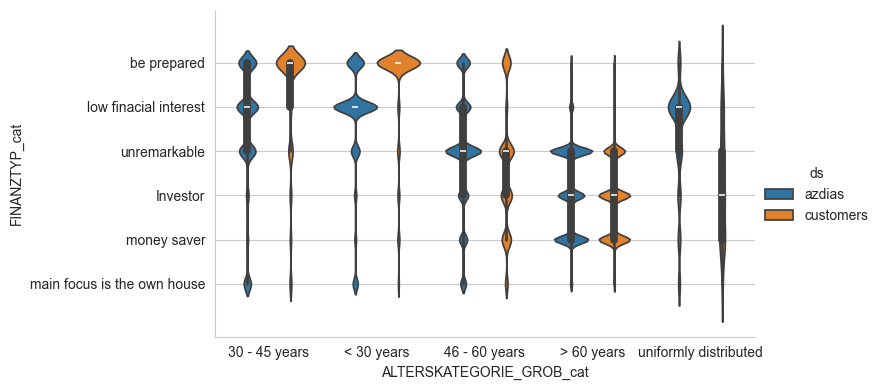

In [64]:
sns.catplot(data = finanztyp_complete, x = "ALTERSKATEGORIE_GROB_cat", y = "FINANZTYP_cat", hue="ds", kind = "violin",height=4, aspect=2);

The individuals can also be classified looking at the Finanztyp. 
* Young people under 30 years seem to have low financial interest in the azdias dataset but are quite prepared in the customers dataset
* In the customers dataset the 30-45 seem also to be rather prepared financially
* the over 60 years old are quite similar concerning the distributions and are money saver, investors but also to a significant amout unremarkable

**PRAEGENDE_JUGENDJAHRE**

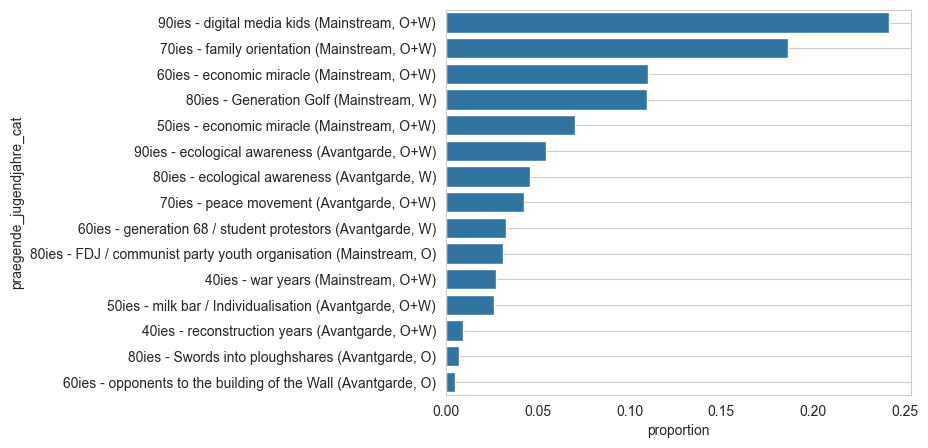

In [65]:
praeg_jugendjahre = azdias[["LNR", "PRAEGENDE_JUGENDJAHRE"]].copy()
praeg_jugendjahre.loc[:, "praegende_jugendjahre_cat"] = praeg_jugendjahre["PRAEGENDE_JUGENDJAHRE"].map(get_mapping("PRAEGENDE_JUGENDJAHRE"))
praeg_jugendjahre_grouped = praeg_jugendjahre["praegende_jugendjahre_cat"].value_counts(normalize=True)

##############
fig,sub = plt.subplots(1,1, figsize=(6,5))

sns.barplot(orient = "h", y = praeg_jugendjahre_grouped.index, x = praeg_jugendjahre_grouped, ax = sub)
sub.grid()

In [66]:
def extract_movement(txt):
    """Extract the movement from the Attribute PRAEGENDE_JUGENDJAHRE	

    Args:
        txt (str): text value of the attribute PRAEGENDE_JUGENDJAHRE	

    Returns:
        str: if extraction works out: movement type, else: input value
    """

    try:

        start_ = re.search(r"\(", txt).start()
        end_ = re.search(r"\)", txt).start() + 1

        return_txt = txt[start_: end_]
        txt_ls = return_txt.split(",")

        return txt_ls[0][1:]
    except:
        
        return txt

In [67]:
praeg_jugendjahre["youth_years"] = praeg_jugendjahre["praegende_jugendjahre_cat"].apply(lambda x: str(x)[:2])
praeg_jugendjahre["movement_type"] = praeg_jugendjahre["praegende_jugendjahre_cat"].str[:].apply(lambda x: extract_movement(x))

In [68]:
pvt_praeg_jugendjahre = pd.pivot_table(
    data = praeg_jugendjahre,
    index = "youth_years",
    columns= "movement_type",
    values= "LNR",
    aggfunc="count"
) 

print("Pivot Movement Type over youth years")
pvt_praeg_jugendjahre

Pivot Movement Type over youth years


movement_type,Avantgarde,Mainstream
youth_years,,
40,7479,21282
50,20451,55195
60,29662,86416
70,33570,145988
80,41516,110254
90,42547,188697


In [69]:
print("Conditional Pivot Movement Type over youth years, axis = 1")

pvt_praeg_jugendjahre_ax_1 = np.round(pvt_praeg_jugendjahre.div(pvt_praeg_jugendjahre.sum(axis = 1), axis = 0),2)
pvt_praeg_jugendjahre_ax_1["All"] = pvt_praeg_jugendjahre_ax_1.sum(axis = 1)
pvt_praeg_jugendjahre_ax_1

Conditional Pivot Movement Type over youth years, axis = 1


movement_type,Avantgarde,Mainstream,All
youth_years,,,
40,0.26,0.74,1.0
50,0.27,0.73,1.0
60,0.26,0.74,1.0
70,0.19,0.81,1.0
80,0.27,0.73,1.0
90,0.18,0.82,1.0


In [69]:
print("Conditional Pivot Movement Type over youth years, axis = 0")

pvt_praeg_jugendjahre_ax_0 = np.round(pvt_praeg_jugendjahre.div(pvt_praeg_jugendjahre.sum(axis = 0), axis = 1),2)
pvt_praeg_jugendjahre_ax_0.loc["All"] = pvt_praeg_jugendjahre_ax_0.sum(axis = 0)
pvt_praeg_jugendjahre_ax_0

Conditional Pivot Movement Type over youth years, axis = 0


movement_type,Avantgarde,Mainstream
youth_years,,
40,0.04,0.04
50,0.12,0.09
60,0.17,0.14
70,0.19,0.24
80,0.24,0.18
90,0.24,0.31
All,1.00,1.00


This attribute contains multiple information at once and describes on the one hand the years in which the individual has grown up and on the other hand to which movement the individual belonged at this time.
After having extracted the relevant information, we can observe:
* that a low proportion of the individuals belong to the youth years = 40 
* that in general over the years the individuals are to a high percentage of the movement Mainstream

This attribute could be useful to segment the individuals.

**Categorical Features** 

Categorical Features can contain useful information for the segmentation, which has to be extracted. In the following, the categorical features are analyzed <br>
if there are potential useful information which should be extracted / used for segmentation.

In [70]:
cat_feats = azdias.dtypes[azdias.dtypes == "object"].index.tolist()
cat_feats

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

Eingefügt am

In [71]:
azdias["EINGEFUEGT_AM"].value_counts()

EINGEFUEGT_AM
1992-02-10 00:00:00    383738
1992-02-12 00:00:00    192264
1995-02-07 00:00:00     11181
2005-12-16 00:00:00      6291
2003-11-18 00:00:00      6050
                        ...  
2006-05-14 00:00:00         1
2005-04-26 00:00:00         1
2012-05-16 00:00:00         1
2007-05-20 00:00:00         1
2000-07-17 00:00:00         1
Name: count, Length: 5162, dtype: int64

This feature seems to be just a general information when the record has been inserted and is rather not useful for the segmentation.<br>
And could therefore be dropped.

OST_WEST_KZ

In [72]:
azdias["OST_WEST_KZ"].isnull().sum() / azdias.shape[0]

np.float64(0.10451728583594866)

In [73]:
azdias["OST_WEST_KZ"].value_counts()

OST_WEST_KZ
W    629528
O    168545
Name: count, dtype: int64

This attribute indicates if the individual lived in the Free Republic of Germany (West) or East Germany (OST) and shows not high missing values percentages.<br>
The feature could be useful to segment the individuals. 

D19_LETZTER_KAUF_BRANCHE

In [74]:
azdias["D19_LETZTER_KAUF_BRANCHE"].isnull().sum() / azdias.shape[0]

np.float64(0.2884952217239046)

In [75]:
azdias["D19_LETZTER_KAUF_BRANCHE"].value_counts()

D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN        

The data could be useful, but the question is if the commercial field of the last purchase (LETZTER KAUF BRANCHE) <br>
is really useful for the general segmentation of the customers.

CAMEO Classification attributes

There are three attribute in relation of the CAMEO Classification. <br>
For a general estimation of the usefulness of the data, the most "rough" classfication can be useful (CAMEO_DEUG_2015).

In [76]:
azdias["CAMEO_DEUG_2015"].isnull().sum() / azdias.shape[0]

np.float64(0.11147852216229195)

In [77]:
map_cameo = get_mapping("CAMEO_DEUG_2015")
map_cameo = {str(k):v for k, v in map_cameo.items()}

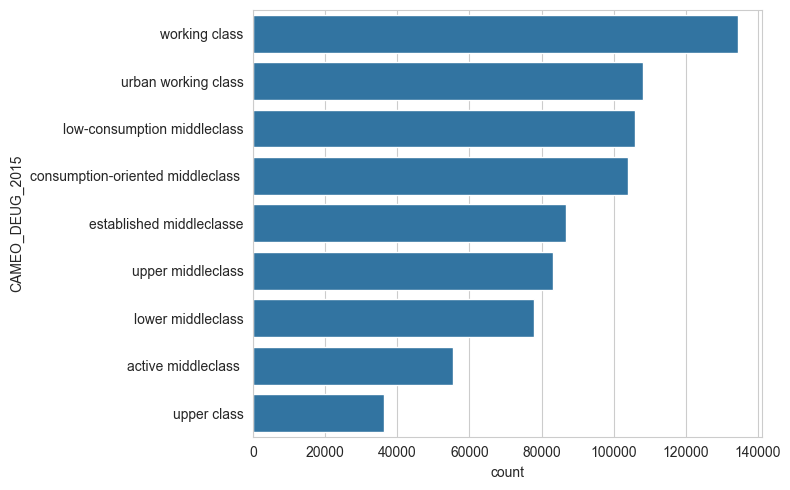

In [78]:
cameo_classif_upper = azdias["CAMEO_DEUG_2015"].to_frame()["CAMEO_DEUG_2015"].map(map_cameo).value_counts()

fig,sub = plt.subplots(1,1,figsize=(8,5))

sns.barplot(orient = "h", y = cameo_classif_upper.index, x = cameo_classif_upper, ax = sub)

fig.tight_layout()

The Cameo Classification attributes could be useful for the segmentation as it divides the customers in meaningful groups

##### (5) Analysis of nunique vals and Correlation Analysis

**Analysis of nunique vals**

In [81]:
nunique_df = {}

for col in azdias.columns:
    nunique_df[col] = azdias[col].nunique()

nunique_df = pd.DataFrame.from_dict(data = nunique_df, orient = "index").rename({0: "nunique_vals"}, axis = 1).sort_values(by = "nunique_vals",ascending=False)

There are several binary variables

In [82]:
nunique_df[nunique_df["nunique_vals"] == 2]

,nunique_vals
VERS_TYP,2
UNGLEICHENN_FLAG,2
SOHO_KZ,2
KBA05_SEG6,2
HH_DELTA_FLAG,2
GREEN_AVANTGARDE,2
KONSUMZELLE,2
DSL_FLAG,2
OST_WEST_KZ,2
ANREDE_KZ,2


As already stated several attributes should be dropped due to high cardinality and low meaningfulness for segmentation

In [83]:
nunique_cat = azdias.select_dtypes(include = ["object"]).nunique()
nunique_cat[nunique_cat>40]

CAMEO_DEU_2015      44
EINGEFUEGT_AM     5162
dtype: int64

In [84]:
cols_too_high_cardinality = nunique_cat[nunique_cat>40].index.tolist()
cols_too_high_cardinality

['CAMEO_DEU_2015', 'EINGEFUEGT_AM']

**Correlation Analysis**

In [87]:
#simulate preprocessing steps
azdias_copy = azdias.copy()

print(f"Before processing: {azdias_copy.shape}")

meaning_less_cols = ["LNR", "EINGEFUEGT_AM", "EINGEZOGENAM_HH_JAHR"]
azdias_copy.drop(meaning_less_cols, axis = 1, inplace = True)

azdias_copy.drop([col for col in cols_too_high_cardinality if col not in meaning_less_cols], axis = 1, inplace = True)

high_missing_val_cols = np.unique(pd.concat([missing_perc_azdias[missing_perc_azdias>0.35], missing_perc_customers[missing_perc_customers>0.35]], axis = 0).index.to_list())
azdias_copy.drop([col for col in high_missing_val_cols.tolist() if col not in cols_too_high_cardinality], axis = 1, inplace = True)

high_missing_val_rows = azdias_copy.isnull().sum(axis = 1)[azdias_copy.isnull().sum(axis = 1) > 25].index
azdias_copy.drop(high_missing_val_rows, axis = 0, inplace = True)

print(f"After processing: {azdias_copy.shape}")

Before processing: (891221, 366)
After processing: (736411, 353)


In [88]:
def create_correlation_report(df, corr_threshold = 0.7):
    """Check the bi-variate correlation in the dataframe and create a list with selected features.
       If a feature-pair shows high correlation, the feature with fewer nan-vals is kept.  

    Inputs:
        df(pandas.DataFrame): Input dataframe
        corr_threshold(float): threshold for the correlation to be defined as high correlated

    Returns:
        list, dict: 
    """

    threshold = 0.7
    processed_cols = [] #already processed or dropped before
    selected_cols = [] #selected features

    high_corr_dict = {} #dictionary for each selected col with the highly correlated (and dropped features)
    nan_matrix = df.isnull().sum().sort_values().reset_index()
    corr_df = df.select_dtypes(exclude=["object"]).corr()

    #looping through the columns of correlation_df
    for col in corr_df.columns:

        if col not in processed_cols:
            
            processed_cols.append(col)
            corr_ls = []
            nan_rank_col = nan_matrix[nan_matrix["index"] == col].index.item()
            selected = True

            for counterpart in corr_df[col].index.tolist():

                if (counterpart not in selected_cols) & (counterpart != col) & (counterpart not in processed_cols):
                    corr_ = corr_df[col].loc[counterpart].item()

                    if abs(corr_) > threshold:
                        
                        if nan_rank_col < nan_matrix[nan_matrix["index"] == counterpart].index.item():
                            corr_ls.append([counterpart, corr_])
                            processed_cols.append(counterpart)
                        else:
                            selected = False
                            break
            
            if selected == True:
                selected_cols.append(col)
                high_corr_dict[col] = corr_ls
        
    return selected_cols, high_corr_dict

In [89]:
selected_cols, high_corr_dict = create_correlation_report(df = azdias_copy, corr_threshold=0.7)

In [90]:
len(selected_cols)

252

In [103]:
not_empty_keys = [k for k in high_corr_dict.keys() if len(high_corr_dict[k])==0]

for k in not_empty_keys:
    del high_corr_dict[k]

high_corr_dict

{'ANZ_HAUSHALTE_AKTIV': [['ANZ_STATISTISCHE_HAUSHALTE', 0.9818121091789779]],
 'ANZ_PERSONEN': [['LP_FAMILIE_FEIN', 0.7900034332073611],
  ['LP_FAMILIE_GROB', 0.7938061743381208],
  ['LP_LEBENSPHASE_FEIN', 0.7591541228219787],
  ['LP_LEBENSPHASE_GROB', 0.7684115459541618]],
 'CJT_TYP_4': [['PRAEGENDE_JUGENDJAHRE', -0.7224780113235991]],
 'D19_BANKEN_ANZ_12': [['D19_BANKEN_ANZ_24', 0.8153103257740911],
  ['D19_BANKEN_DATUM', -0.749575881901876],
  ['D19_BANKEN_ONLINE_DATUM', -0.704723032465713],
  ['D19_BANKEN_ONLINE_QUOTE_12', 0.787408040321215]],
 'D19_GESAMT_ANZ_12': [['D19_GESAMT_ANZ_24', 0.9029607564162848],
  ['D19_GESAMT_DATUM', -0.8185020390991988],
  ['D19_GESAMT_ONLINE_DATUM', -0.7971540177604196],
  ['D19_GESAMT_ONLINE_QUOTE_12', 0.7170348989141005],
  ['D19_VERSAND_ANZ_12', 0.9027964926612584],
  ['D19_VERSAND_ANZ_24', 0.8507218049554153],
  ['D19_VERSAND_DATUM', -0.7872162621593911],
  ['D19_VERSAND_ONLINE_DATUM', -0.772123871422377]],
 'D19_GESAMT_OFFLINE_DATUM': [['D19_VE

In [106]:
#columns to drop
np.setdiff1d(
    ar1 = azdias_copy.columns,
    ar2 = selected_cols,
    assume_unique=True
)

array(['ALTERSKATEGORIE_FEIN', 'ANZ_STATISTISCHE_HAUSHALTE',
       'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_TYP_1', 'CJT_TYP_2',
       'CJT_TYP_3', 'CJT_TYP_5', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_QUOTE_12',
       'EWDICHTE', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FIRMENDICHTE',
       'GEBAEUDETYP_RASTER', 'GEMEINDETYP', 'KBA05_ANTG1',
       'KBA05_AUTOQUOT', 'KBA05_GBZ', 'KBA05_KRSHERST1',
       'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KW2', 'KBA05_SEG2',
       'KBA05_SEG5',

The correlation analysis can be useful to drop those features which contain the more or less the same information. 
So in the analysis above, after having manually dropped several features we could delete ~ 100 features which are highly correlated with other existing ones. 
But we have to be careful in further Data Preparation that features such as "PRAEGENDE_JUGENDJAHRE" which we want explicitly to include are not exluded with this procedure.<br>

In general, we can postulate that there are quite many redundancies concerning the information content between the features. 
This is something we have to adress in data preparation.

##### (6) Conclusion

In this exploratory Data Analysis, the following findings have been discovered:
* <u> General information about the population:</u>
    * there are nearly equally men and women in the dataset 
    * the individuals are mostly german and of a higher age class (~46 - 60 years, around 40-50 %) 
    * they are living to a high stake in single or 2 and more generation households 
    * whereas the individuals are mostly low-income earners and are concerning the "movement" in the youth years more likely mainstream and less avantgarde

* <u>Missing values:</u>
    * looking at the description of the datasets, there are some values in the attributes declared as "unknown". These values can be classified as missing and has to be mapped in the data preparation phase
    * we do have several columns with high percentage of missing values and these columns should be dropped in data preparation
    * we do have several rows / individuals with more than 25 features which do not show values (nan values) and these data should be dropped in data preparation
    
* <u>Non informative columns:</u>
    * there are some columns which do not contain valuable information for the segmentation task (e.g. "LNR", "EINGEFUEGT_AM", "EINGEZOGENAM_HH_JAHR"). So these attributes can be dropped in the data preparation phase.

* <u>Skewed Features:</u>
    * some features in the dataset are highly skewed. These features should be transformed for the further data processing.

* <u>Feature Engineering Steps:</u>
    * especially the attribute "Praegende_Jugendjahre" is of str type and contains beside the decade in which the individual lived in his youth years also the information if the person has been rather avantgardist or more mainstream positioned.
    * the extraction of these information has to be adressed in data preparation

* <u>Highly correlated features:</u>
    * the dataset contains in total around 360 features. These 360 features can be reduced to around 353 features by following the steps above. But looking at the correlation analysis, there are several attributes which are expressing the same information and it's possible to drop one of a respective feature pair if they are expressing a high amount of the same information (high correlation)
    * these steps have to be adressed in data preparation

* <u>Normalization:</u>
    * in addition to the steps above, to prevent that the scale of the relevant features dominate / bias the PCA, a normalization step has to be executed